In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install numpy pandas scikit-learn matplotlib torch_geometric rdkit

In [ ]:
import zipfile
import os
import pandas as pd
from rdkit import Chem
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the CSV into a DataFrame
df = pd.read_csv("/content/drive/My Drive/solubility/sol_des_clean.zip",compression='zip')
# Display the first few rows
df.head()

**Step 1: Plot to examine distribution of solubility data**

In [ ]:
import plotly.graph_objects as go
# Step 2: Select the first 5 rows and 10 columns
subset_df = df.iloc[:5, [0, 1] + list(range(5, 9))] #df.iloc[:5, :5]  # First 5 rows, 10 columns
# Format numeric columns to 4-digit format
numeric_columns = subset_df.select_dtypes(include=['int64', 'float64']).columns  # Identify numeric columns
# Apply 4-digit formatting (e.g., '0001' for numbers)
subset_df[numeric_columns] = subset_df[numeric_columns].applymap(lambda x: f"{x:04d}" if isinstance(x, int) else f"{x:.4f}")

# Step 3: Create the interactive table with Plotly
fig = go.Figure(data=[go.Table(
    header=dict(values=subset_df.columns),
    cells=dict(values=[subset_df[col] for col in subset_df.columns])
)])
fig.update_layout(
    height=600,  # Adjust height (make it shorter)
    width=1000,   # Adjust width (optional, can also be made narrower if desired)
)

fig.show()

**Plot Boxplot**

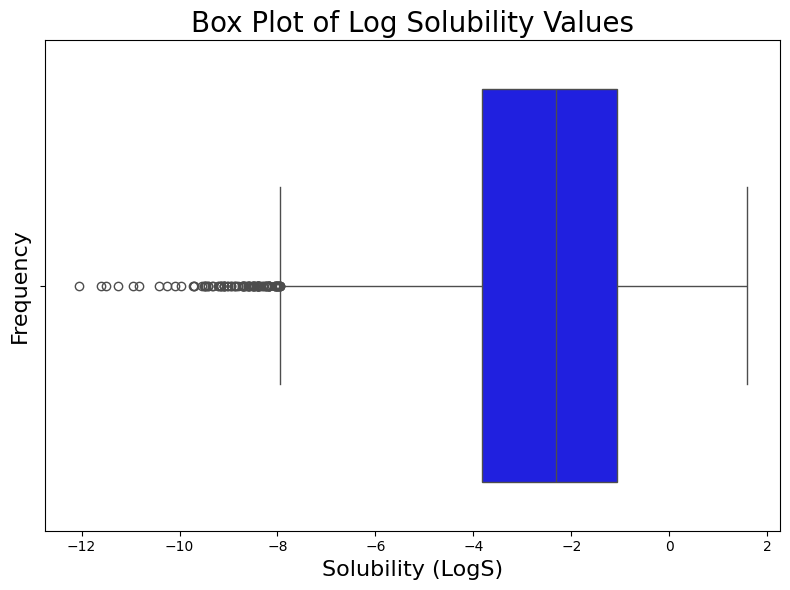

In [ ]:
# Create a boxplot for solubility values
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['LogS'], color='blue')

# Add labels and title
plt.xlabel('Solubility (LogS)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Box Plot of Log Solubility Values', fontsize=20)

# Show the plot
plt.tight_layout()
plt.show()

**Histogram plot**

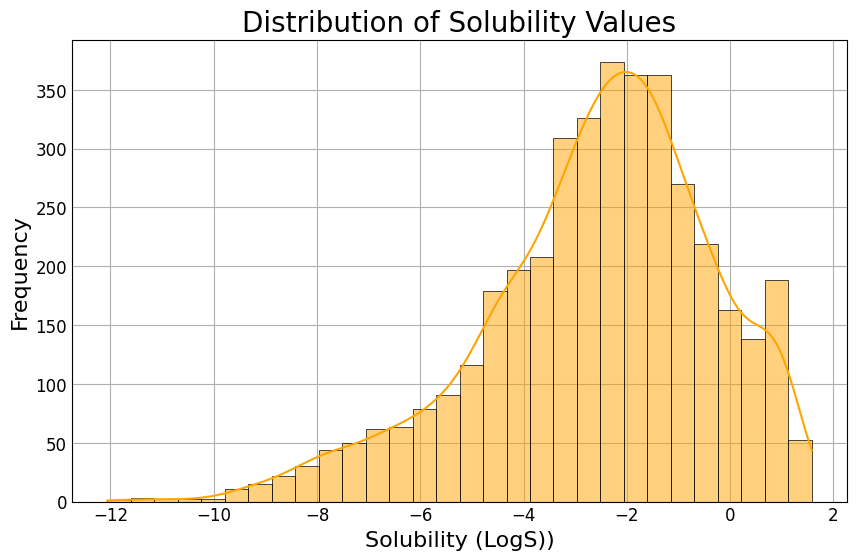

In [ ]:
# Set the size of the plot
plt.figure(figsize=(10, 6))
plt.style.use('_mpl-gallery') # Use the _mpl-gallery style

# Plot the histogram using seaborn
sns.histplot(df['LogS'], kde=True, bins=30, linewidth=0.5, color="orange", edgecolor="black")

# Customize the plot
plt.title('Distribution of Solubility Values', fontsize=20)
plt.xlabel('Solubility (LogS))', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.tick_params(axis='both', labelsize=12)

# Show the plot
plt.show()

**Step 2: Cleaning data: by removing outliers**

In [ ]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['LogS'].quantile(0.25)
Q3 = df['LogS'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define the outlier threshold
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('Outlier lower bound:', lower_bound, ', upper bound:', upper_bound)
# Remove outliers from the solubility values
df_final = df[(df['LogS'] >= lower_bound) & (df['LogS'] <= upper_bound)]

# Show the updated DataFrame (without outliers)
df_final.head()

Outlier lower bound: -7.946125 , upper bound: 3.056875


,SMILES,LogS,assigned weight based on quality,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,BrC(Br)(Br)Br,-3.140,1.0,0.0,0.0,4.000000,2.000000,4.000000,4.000000,0.800000,...,7.625107,29.418928,327.673348,65.534670,16.0,0.0,20.0,16.0,4.062500,1.000000
1,BrC(Br)Br,-1.808,1.0,0.0,0.0,3.464102,1.732051,3.464102,3.464102,0.866025,...,6.188264,24.179697,249.762836,49.952567,9.0,0.0,12.0,9.0,3.111111,1.000000
2,BrC(Br)C(Br)Br,-2.732,1.0,0.0,0.0,6.000000,2.000000,4.000000,6.000000,1.000000,...,7.626083,30.698690,341.688998,42.711125,29.0,4.0,22.0,21.0,4.222222,1.444444
3,BrC1CCCCC1,-2.294,1.0,0.0,0.0,8.720566,2.101003,4.202006,8.720566,1.245795,...,8.124151,33.544698,162.004412,9.000245,42.0,5.0,30.0,31.0,2.361111,1.666667
4,BrCBr,-1.165,1.0,0.0,0.0,2.828427,1.414214,2.828427,2.828427,0.942809,...,4.174387,17.310771,171.852324,34.370465,4.0,0.0,6.0,4.0,2.250000,1.000000


*Final numbers of compounds and descriptors*

In [ ]:
print('# of moleculars:', len(df_final), ';# of descriptors:', len(df_final.columns), )

# of moleculars: 3849 ;# of descriptors: 1518


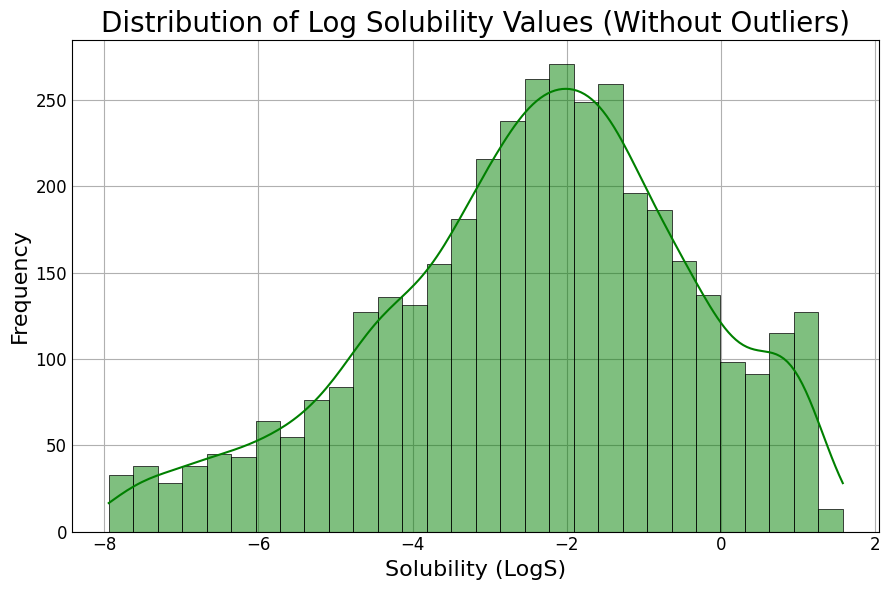

In [ ]:
# Set the size of the plot
plt.figure(figsize=(9, 6))
plt.style.use('_mpl-gallery') # Use the _mpl-gallery style
# Plot the histogram using seaborn
sns.histplot(df_final['LogS'], kde=True, bins=30, linewidth=0.5, color="green", edgecolor="black")
# Customize the plot
plt.title('Distribution of Log Solubility Values (Without Outliers)', fontsize=20)
plt.xlabel('Solubility (LogS)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()

# Show the plot
plt.show()

**Step 3: Descriptor Standardization (also called normalization) transforms descriptors to have a mean of 0 and a standard deviation of 1. This helps Neural Network and Gradient Boosting Models perform better.**

In [ ]:
df_x = df_final.iloc[:, 3:1518]  # Selects columns starting from index 7 (i.e., continuous predictors/features)
df_y = df_final["LogS"]   # Target: log_Solubility
print(df_x)
print(df_y)

In [ ]:
# Calculate mean and standard deviation
x_mean = df_x.mean()  # Mean for each feature column
x_sd = df_x.std()    # Standard deviation for each feature column
# Standardizing data
df_x = (df_x - x_mean) / x_sd
# Drop NaN values
df_x = df_x.dropna(axis=1)
# Check how many left
print('Numbers of molecules:', len(df_x), '  ; Numbers of descriptors:',len(df_x.columns) )
# Check mean and SD
print(df_x.mean())  # Should be close to 0
print(df_x.std())   # Should be close to 1

**Step 4: Splitting training and test sets**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=100)
print('Training Set:', len(X_train))
print('Test Set:', len(X_test))

Training Set: 3079
Test Set: 770


In [ ]:
X_train

**Step 5: Feature important selection using Lasso Regression**
With close to 1000 descriptors, it maybe too many, we'll select only important descriptors to feed into ML models.

In [ ]:
import numpy as np
from sklearn.linear_model import Lasso
# Initialize Lasso model
lasso = Lasso(alpha=0.01, max_iter = 50000)  # alpha is the regularization strength
# Fit the model
lasso.fit(X_train,  Y_train)

# Get coefficients (important features have larger coefficients)
non_zero_coef = np.where(lasso.coef_ != 0)[0]
selected_features = X_train.columns[non_zero_coef]
print("Top features selected by Lasso:", selected_features)
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]


Top features selected by Lasso: Index(['nAcid', 'nBase', 'nSpiro', 'nBridgehead', 'AATS1dv', 'AATS2dv',
       'AATS0d', 'AATS2d', 'AATS1i', 'ATSC2dv',
       ...
       'JGI3', 'JGI5', 'JGI7', 'JGI8', 'JGI10', 'Diameter', 'TopoShapeIndex',
       'SRW03', 'SRW05', 'WPath'],
      dtype='object', length=158)


**Plotting Top 10 Important Features**

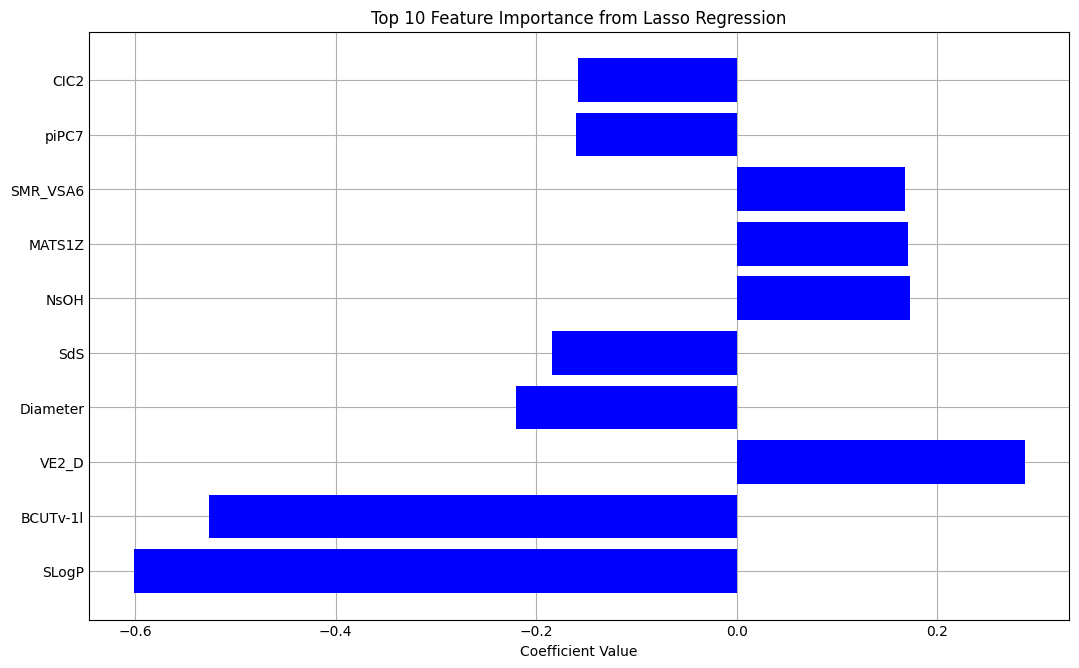

In [ ]:
# Create a DataFrame to hold the feature names and their corresponding coefficients
# Get the coefficients and their corresponding features
coefficients = lasso.coef_
feature_names = X_train.columns

# Create a DataFrame to associate feature names with their coefficients
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Filter out the features with zero coefficients
importance_df = importance_df[importance_df['Coefficient'] != 0]
# Sort the features by the absolute value of their coefficients
importance_df['Abs Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Abs Coefficient', ascending=False)

# Select top 10 important features
top_10_features = importance_df.head(10)

# Plot the top 10 feature importances (coefficients)
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Coefficient'], color='b')
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Importance from Lasso Regression')
plt.show()

**Subset the orginial dataset with only important features**

In [ ]:
x_mean_reduced = x_mean[selected_features]
x_sd_reduced = x_sd[selected_features]
mean_sd_train = pd.concat([x_mean_reduced, x_sd_reduced], axis=1)
mean_sd_train = mean_sd_train.set_axis(['mean', 'sd'], axis=1)
mean_sd_train.to_csv('/content/drive/My Drive/solubility/sol_mean_sd_train_clean.csv', index=True)

In [ ]:
# select useful predictors
X_train_reduced =  X_train_reduced.values;
X_test_reduced = X_test_reduced.values
Y_train_ary = Y_train.values;
Y_test_ary = Y_test.values

In [ ]:
# Ensure the input data is in the correct format before converting to tensors
print(f"X_train_reduced shape: {X_train_reduced.shape}")
print(f"Y_train shape: {Y_train.shape}")

X_train_reduced shape: (3079, 158)
Y_train shape: (3079,)


**Step 6: Extract graph-based features using pre-trained Graph Neural Network model**


**Prepare Molecular Graph Data for the GNN:**
With the original dataset, convert the molecular structures, SMILES, into graph representations for the GNN using RDKit

In [ ]:
# Convert SMILES to RDKit Molecule objects
df_final.loc[:, 'mol'] = df_final['SMILES'].apply(Chem.MolFromSmiles)
df_final.head()

**Each molecule will be represented as a graph with atoms as nodes and bonds as edges.**

In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
def mol_to_graph_data(mol, LogS):
    """
    Converts an RDKit molecule to a PyTorch Geometric Data object.
    """
    # Get atom features (atomic number)
    atom_features = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    x = torch.tensor(atom_features, dtype=torch.float).view(-1, 1)

    # Get bond information (edges)
    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
# Create a Data object
    data = Data(x=x, edge_index=edge_index, y=torch.tensor([LogS], dtype=torch.float))
    return data

In [ ]:
# Convert dataset to graph data
graph_data = [mol_to_graph_data(mol, sol) for mol, sol in zip(df_final['mol'], df_final['LogS'])]


In [ ]:
print(graph_data[:5]) #check first 5 elements

[Data(x=[5, 1], edge_index=[2, 8], y=[1]), Data(x=[4, 1], edge_index=[2, 6], y=[1]), Data(x=[6, 1], edge_index=[2, 10], y=[1]), Data(x=[7, 1], edge_index=[2, 14], y=[1]), Data(x=[3, 1], edge_index=[2, 4], y=[1])]


**Split data containing solubulity and graph features for GNN training**

In [ ]:
# Train-test split
train_data, test_data = train_test_split(graph_data, test_size=0.2, random_state=100)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)


**Define a simple GNN model**

In [ ]:
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Global pooling
        x = self.lin(x)
        return x

**Step 7: Train the GNN model with training graph data above**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass through the model
        out = model(data.x, data.edge_index, data.batch)

        # Reshape target to match output shape (e.g., [batch_size, 1])
        target = data.y.view(-1, 1)  # or data.y.unsqueeze(1)

        # Compute the loss
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

Save the trained GNN model, so we can load later if needed.

In [ ]:
torch.save(model, '/content/drive/MyDrive/solubility/gnn_model_clean.pth')

**Step 8: Extract Features from the trained GNN**
Once the GNN is trained, we’ll use it to extract molecular features, which will be combined with the Mordred descriptors.

In [ ]:
def extract_features(loader):
    model.eval()
    features = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            features.append(out.cpu().numpy())
    return np.concatenate(features)
train_features = extract_features(train_loader)
test_features = extract_features(test_loader)


In [ ]:
train_features

array([[0.6329719 ],
       [0.59798986],
       [0.629371  ],
       ...,
       [0.64434177],
       [0.95090616],
       [0.74394727]], dtype=float32)

In [ ]:
# Summary statistics
dftr = pd.DataFrame(train_features, columns=["Value"])
summary_train = dftr.describe()
dfte = pd.DataFrame(test_features, columns=["Value"])
summary_test = dfte.describe()
print("Training GNN Feature Set Summary:")
print(summary_train)
print("\nTest GNN Feature Set Summary:")
print(summary_test)


Training GNN Feature Set Summary:
             Value
count  3079.000000
mean      0.703896
std       0.157081
min       0.568721
25%       0.620569
50%       0.647740
75%       0.733102
max       2.728399

Test GNN Feature Set Summary:
            Value
count  770.000000
mean     0.716194
std      0.194094
min      0.574296
25%      0.623724
50%      0.652698
75%      0.737394
max      2.814171


In [ ]:
dftr

Train an Neural Network Model with Combined Features
Now, we’ll concatenate the GNN features with the molecular descriptors and train an NN model.

In [ ]:
# Concatenate GNN features with descriptors
X_train_combined = np.hstack((train_features, X_train_reduced))
X_test_combined = np.hstack((test_features, X_test_reduced))

In [ ]:
X_train_reduced

In [ ]:
# Save X_train and y_train as NumPy binary files
path = '/content/drive/MyDrive/solubility/sol_data_clean/'
np.save(os.path.join(path, 'X_train_combined.npy'),X_train_combined )
np.save(os.path.join(path,'X_test_combined.npy'),X_test_combined)
np.save(os.path.join(path, 'Y_train.npy'),Y_train)
np.save(os.path.join(path, 'Y_test.npy'), Y_test)

**Display a molecule using RDKit and its SMILES**

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

# Create a molecule object from a SMILES string
smiles = "CC(=O)Oc1ccccc1C(=O)O"  # Ethanol
mol = Chem.MolFromSmiles(smiles)

# Display the molecule
Draw.MolToImage(mol)

**Visualize a molecule structure with positions**

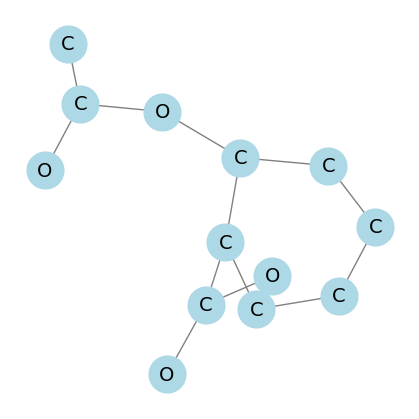

In [ ]:
import networkx as nx

# Example SMILES string (for ethanol)
smiles = 'CC(=O)Oc1ccccc1C(=O)O'

# Convert SMILES to RDKit molecule object
mol = Chem.MolFromSmiles(smiles)

# Create an empty graph
G = nx.Graph()

# Add nodes with features
for atom in mol.GetAtoms():
    atom_idx = atom.GetIdx()  # Atom index
    atom_type = atom.GetSymbol()  # Atom type (e.g., 'C', 'O')

    # Add node with features (you can add other features such as atom type, charge, etc.)
    G.add_node(atom_idx, label=atom_type)

# Add edges (bonds)
for bond in mol.GetBonds():
    atom1 = bond.GetBeginAtomIdx()
    atom2 = bond.GetEndAtomIdx()

    # Add undirected edges between atoms
    G.add_edge(atom1, atom2)

# Draw the graph (visualize the molecule)
plt.figure(figsize=(4, 4))  # Larger plot size
pos = nx.spring_layout(G, seed=42, k=0.5)  # Adjust k for spacing
nx.draw(G, pos, with_labels=False, node_size=700, node_color='lightblue', edge_color='gray')

# Add atom type labels
atom_labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=atom_labels, font_size=14, font_color='black')

# Adjust label positions if needed to avoid overlap (slightly adjust y-coordinate)
label_pos = {key: [x, y + 0.1] for key, (x, y) in pos.items()}  # Slightly adjust y-axis for better visibility

# Add node indices labels (if you want them)
node_labels = {i: str(i) for i in G.nodes()}
#nx.draw_networkx_labels(G, label_pos, labels=node_labels, font_size=10, font_color='red')

#plt.title("Molecule Graph Visualization from SMILES")
plt.show()


**Example of node features as input for GNN**

In [ ]:
node_features = []
for atom in mol.GetAtoms():
    atom_number = atom.GetAtomicNum()  # Atomic number
    node_features.append(atom_number)

# Convert node_features to a numpy array (for GNN input)
node_features = np.array(node_features)
print("Node features (atomic numbers):", node_features)


Node features (atomic numbers): [6 6 8 8 6 6 6 6 6 6 6 8 8]


Node features (atomic numbers): [6 6 8 8 6 6 6 6 6 6 6 8 8]


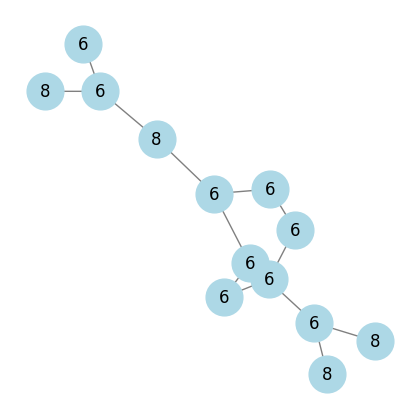

In [ ]:
# Example SMILES string
smiles = 'CC(=O)Oc1ccccc1C(=O)O'

# Convert SMILES to RDKit molecule object
mol = Chem.MolFromSmiles(smiles)

# Extract node features (atomic numbers)
node_features = []
for atom in mol.GetAtoms():
    atom_number = atom.GetAtomicNum()  # Atomic number
    node_features.append(atom_number)

# Convert node_features to a numpy array (for GNN input)
node_features = np.array(node_features)
print("Node features (atomic numbers):", node_features)

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for atom_idx in range(len(node_features)):
    G.add_node(atom_idx)

# Add edges (bonds)
for bond in mol.GetBonds():
    atom1 = bond.GetBeginAtomIdx()
    atom2 = bond.GetEndAtomIdx()
    G.add_edge(atom1, atom2)

# Draw the graph
plt.figure(figsize=(4, 4))  # Set plot size
pos = nx.spring_layout(G, seed=42)  # Positioning nodes using spring layout

# Draw nodes and edges
nx.draw(G, pos, with_labels=False, node_size=700, node_color='lightblue', edge_color='gray')

# Create labels with node features (atomic numbers)
node_labels = {i: f"{node_features[i]}" for i in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_color='black')

# Display plot
#plt.title("Molecule Graph with Atomic Numbers as Node Features")
plt.show()
